In [1]:
import matplotlib.pyplot as plt
import perlin_noise
from particle import ThermalParticleDistribution
import numpy as np
from isometrics import create_iso_lines, xyz_to_iso_xy
from matplotlib.collections import LineCollection
import matplotlib.animation as animation
import random



In [2]:
DIM_X = 60
DIM_Y = 60
noise_layers = [perlin_noise.noise_map(DIM_X, DIM_Y, i) for i in range (1, 25, 5)]


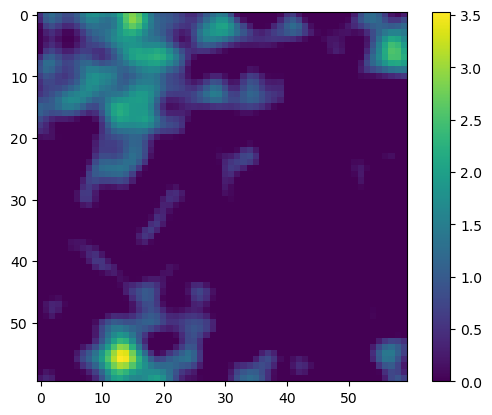

In [3]:
map_layer = np.sum([noise_layers[0]*10, noise_layers[1]*4,  noise_layers[2]*3], axis=0)
map_layer *= DIM_X/100
for x_index in range(len(map_layer)):
    for y_index in range(len(map_layer[0])):
        if map_layer[x_index][y_index] < -.5:
            map_layer[x_index][y_index] = -.5
        map_layer[x_index][y_index] += 0.5

plt.imshow(map_layer.transpose())
plt.colorbar()

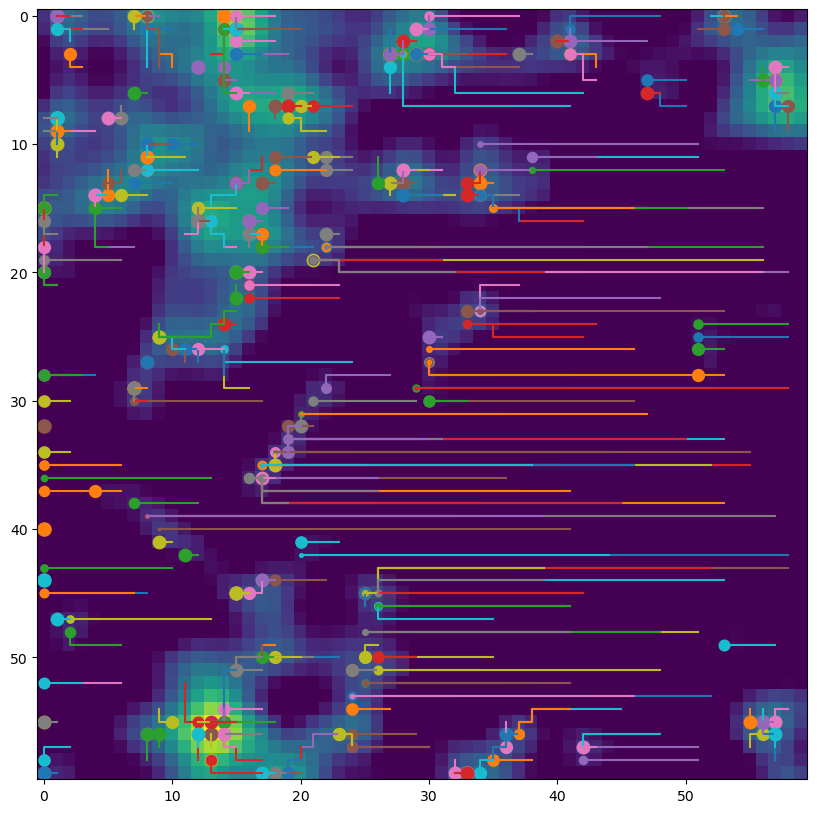

In [7]:
particles = []

# Hot air distribution over elevation 
while len(particles) < 500:
    new_particle = DiscreteThermalParticle(random.randrange(DIM_X), random.randrange(DIM_Y))
    elevation = map_layer[new_particle.position_x][new_particle.position_y]
    # Min elevation is 0. Add 1 to have a baseline 75% chance, increasine with elevation
    prob = elevation + 1.2
    if ((prob * random.random()) > 1):
        particles.append(new_particle)


particle_trail = [{"x": [], "y":[], "heat":[]} for _ in range(len(particles))]
fig, ax = plt.subplots(figsize=(16, 10))
ax.imshow(map_layer.transpose())
for _ in range(500):
    for index, particle in enumerate(particles): 
        if not particle.released:
            particle.step_dynamics(map_layer, wind = (-10, 0))
            particle_trail[index]["x"].append(particle.position_x)
            particle_trail[index]["y"].append(particle.position_y)
            particle_trail[index]["heat"].append(particle.heat_energy)

for particle in particle_trail:
    ax.plot(particle["x"], particle["y"])
    ax.scatter(particle["x"][-1], particle["y"][-1], s=particle["heat"][-1])

(0.0, 30.0)

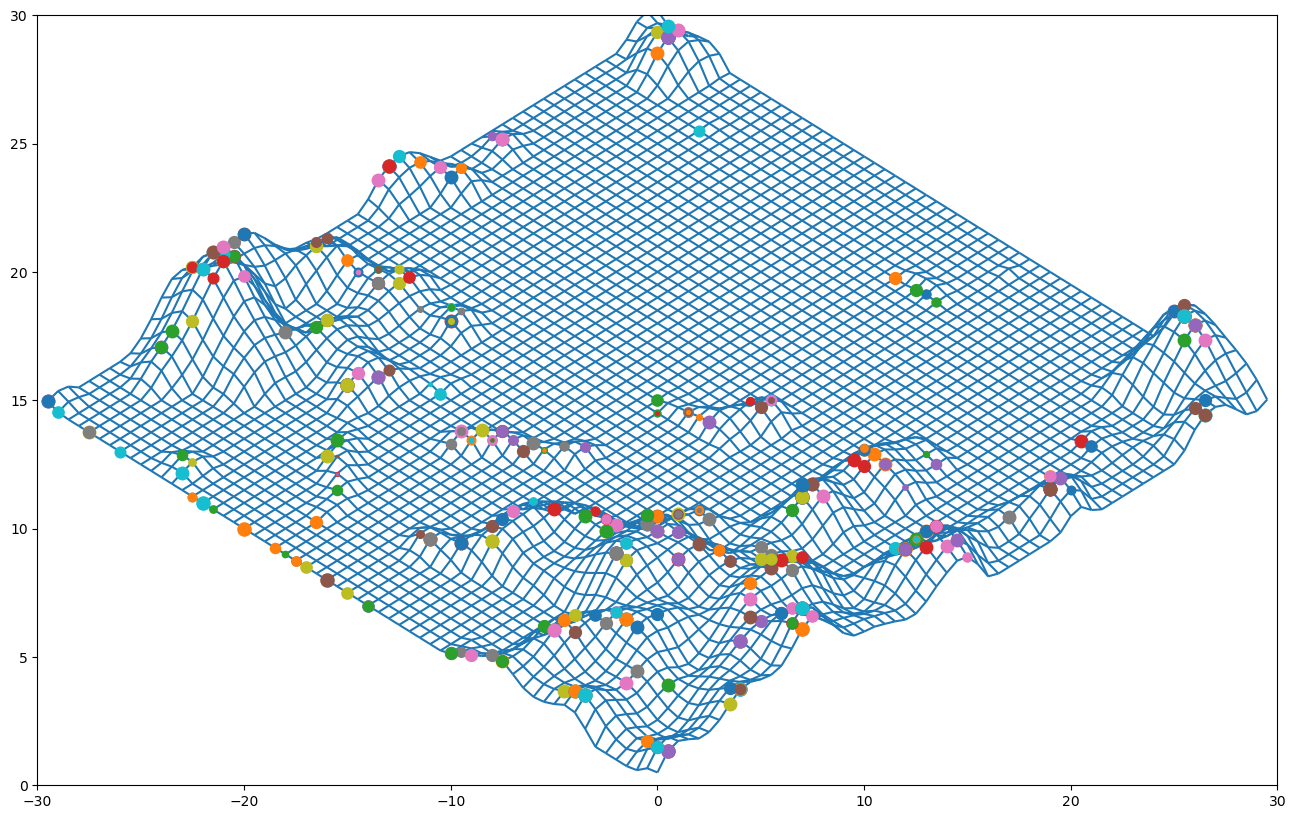

In [8]:
iso_lines = create_iso_lines(map_layer)
plane = [int(DIM_X/3), int(4*DIM_Y/5), 3]
plane_ground = xyz_to_iso_xy(plane[0], plane[1], map_layer[plane[0]][plane[1]])
plane_air = xyz_to_iso_xy(plane[0], plane[1], plane[2])
lc = LineCollection(iso_lines, zorder=0)
# Create a figure and axes
fig, ax = plt.subplots(figsize=(16,10))


for particle in particle_trail:
    x_release = particle["x"][-1]
    y_release = particle["y"][-1]
    heat = particle["heat"][-1]
    loc = xyz_to_iso_xy(x_release, y_release, map_layer[x_release][y_release])
    ax.scatter(loc[0], loc[1], s=heat)
    
# Add the LineCollection to the axes
ax.add_collection(lc)
ax.set_xlim(-DIM_X/2, DIM_X/2)
ax.set_ylim(0, DIM_Y/2)

MovieWriter imagemagick unavailable; using Pillow instead.


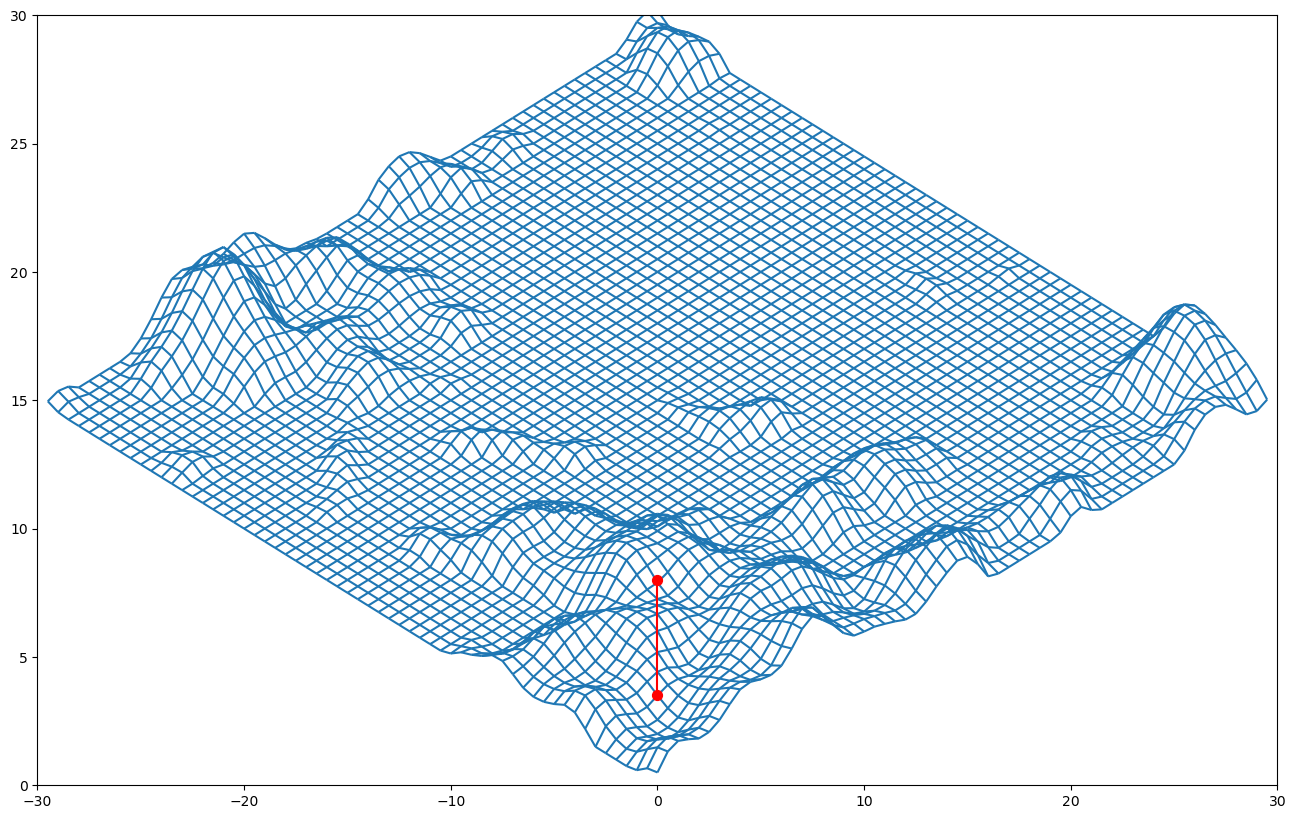

In [6]:
iso_lines = create_iso_lines(map_layer)
plane = [int(DIM_X/3), int(4*DIM_Y/5), 5]
plane_ground = xyz_to_iso_xy(plane[0], plane[1], map_layer[plane[0]][plane[1]])
plane_air = xyz_to_iso_xy(plane[0], plane[1], plane[2])
lc = LineCollection(iso_lines, zorder=0)
# Create a figure and axes
fig, ax = plt.subplots(figsize=(16,10))

# Add the LineCollection to the axes
ax.add_collection(lc)
ground_point = ax.scatter(plane_air[0], plane_air[1], c="red", zorder=10, s = 50)
connection_line, = ax.plot([plane_air[0], plane_ground[0]],  [plane_air[1], plane_ground[1]], c="red")
ax.set_xlim(-DIM_X/2, DIM_X/2)
ax.set_ylim(0, DIM_Y/2)

def update(num, ground_point, connection_line):
    
    if num < 100:
        y = int(DIM_Y/10)
        x = int((num/100 * DIM_X * 4/5) + DIM_X/10)
    elif num < 200:
        y = int(((num-100)/100 * DIM_Y * 4/5) + DIM_Y/10)
        x = int(9 * DIM_X/10)
    elif num < 300:
        y = int(9*DIM_Y/10)
        x = int(-((num-200)/100 * DIM_X * 4/5) + 9*DIM_X/10)
    else:
        y = int(-((num-300)/100 * DIM_Y * 4/5) + 9*DIM_Y/10)
        x = int(DIM_X/10)

    plane_ground = xyz_to_iso_xy(x, y, map_layer[x][y])
    plane_air = xyz_to_iso_xy(x, y, plane[2])

    ground_point.set_offsets([plane_ground, plane_air])
    connection_line.set_data([plane_air[0], plane_ground[0]], [plane_air[1], plane_ground[1]])
    return ground_point, connection_line,

ani = animation.FuncAnimation(fig, update, 400, interval=200, 
                              fargs=[ground_point, connection_line], blit=True)

ani.save('animation_drawing_large.gif', writer='imagemagick', fps=60)
